# ML Flow on Azure ML

The ML ops demo notebook shows running ML Flow on a local machine, and the AzureML notebook demonstrates using the Azure ML SDK for experiment tracking. This notebook combines the two, using AzureML to run, but tracking through the ML Flow API with AzureML providing the backend storage. This allows us to make use of the easily scaling  infrastructure of AzureML, while the code is still portable as other backends can easily be swapped in when required.


In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
%load_ext tensorboard

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import mean_absolute_error, r2_score

In [5]:
import mlflow
mlflow.tensorflow.autolog()

2022/05/04 15:05:34 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [11]:
import prd_pipeline

### Load data

In [16]:
import azureml.core
from azureml.core import Workspace, Datastore, Dataset
from azureml.core import Experiment

prd_ws = Workspace.from_config()

In [12]:
azure_dataset_name ='sd3'
azure_experiment_name='prd_mlops_test'
azure_env_name = 'prd_ml_cluster'
cluster_name = 'mlops-test'

In [13]:
prd_model_name = 'azml_mlflow_20220504'

In [14]:
target_parameter = 'rainfall_rate_composite'
profile_features = ['air_temperature', 'relative_humidity']
single_lvl_features = ['air_pressure_at_sea_level'] 

In [9]:
mlflow.set_tracking_uri(prd_ws.get_mlflow_tracking_uri())

In [17]:
input_data = prd_pipeline.load_data(
    prd_ws,
    dataset_name=azure_dataset_name
)
data_splits, data_dims = prd_pipeline.preprocess_data(
    input_data,
    feature_dict={'profile': profile_features, 'single_level': single_lvl_features,'target': target_parameter,},
)


{'profile': ['air_temperature', 'relative_humidity'], 'single_level': ['air_pressure_at_sea_level'], 'target': 'rainfall_rate_composite'}


In [19]:
data_dims

{'nprof_features': 2, 'nheights': 33, 'nsinglvl_features': 1}

In [20]:
nprof_features = data_dims['nprof_features'] 
nheights = data_dims['nheights']
nsinglvl_features = data_dims['nsinglvl_features']

In [21]:
exp1 = mlflow.create_experiment('prd_exp_azml_mlflow')
exp1

'f1ebd4da-78ee-4b70-9d2c-5b9c5fb75ea9'

In [22]:
exp1 = mlflow.get_experiment(exp1)

In [23]:
exp1

<Experiment: artifact_location='', experiment_id='f1ebd4da-78ee-4b70-9d2c-5b9c5fb75ea9', lifecycle_stage='active', name='prd_exp_azml_mlflow', tags={}>

In [25]:
import datetime
log_dir = 'log/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [26]:
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# run tensorboard --logdir LOGDIRPATH from command line to launch 

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, s=200, c='darkblue')
plt.gca().plot([0, 300], [0, 300], ls="--", c=".3")
plt.xlabel('Actual 3hr precip accumulation value')
plt.ylabel('Predicted 3hr precip_accumulation value')
plt.show()

In [30]:
import tempfile

In [45]:
with mlflow.start_run(experiment_id=exp1.experiment_id, run_name='run1') as current_run:
    model = prd_pipeline.build_model(nprof_features, nheights, nsinglvl_features)
    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    history = model.fit(data_splits['X_train'], data_splits['y_train'], epochs=1, batch_size=32, validation_split=0.25, verbose=True, callbacks=[tensorflow_callback])

    y_pred = model.predict(data_splits['X_test'])
    error = mean_absolute_error(data_splits['y_test'], y_pred)
    print(f'MAE: {error:.3f}')
    rsqrd = r2_score(data_splits['y_test'], y_pred)
    print(f'R-squared score: {rsqrd:.3f}')
    
    mlflow.log_metric('MAE', error)
    mlflow.log_metric('R-squared', rsqrd)
    
    fig1 = plt.figure(figsize=(10, 8))
    ax1 = fig1.add_subplot(1,1,1)
    ax1.scatter(data_splits['y_test'], y_pred, s=200, c='darkblue')
    ax1.plot([0, 300], [0, 300], ls="--", c=".3")
    ax1.set_xlabel('Actual 3hr precip accumulation value')
    ax1.set_ylabel('Predicted 3hr precip_accumulation value')
#     with tempfile.TemporaryDirectory() as td1:
        
#         fig1.savefig(plot_out_path, bbox_inches='tight')
    mlflow.log_figure(fig1,  'actual_predicted_precip_3hr.png')                   
    # mlflow.log


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 2)]      0           []                               
                                                                                                  
 zero_padding1d_18 (ZeroPadding  (None, 35, 2)       0           ['profile_input[0][0]']          
 1D)                                                                                              
                                                                                                  
 conv1d_18 (Conv1D)             (None, 33, 32)       192         ['zero_padding1d_18[0][0]']      
                                                                                                  
 zero_padding1d_19 (ZeroPadding  (None, 35, 32)      0           ['conv1d_18[0][0]']        

If we look at the experiment in AzureML GUI, we see that all the model parameters have been automatically logged, and the model has been saved by ML Flow ready for use in inference.

## Evaluation

In [48]:
training_hist_df = pd.DataFrame(history.history)
training_hist_df['epoch'] = history.epoch

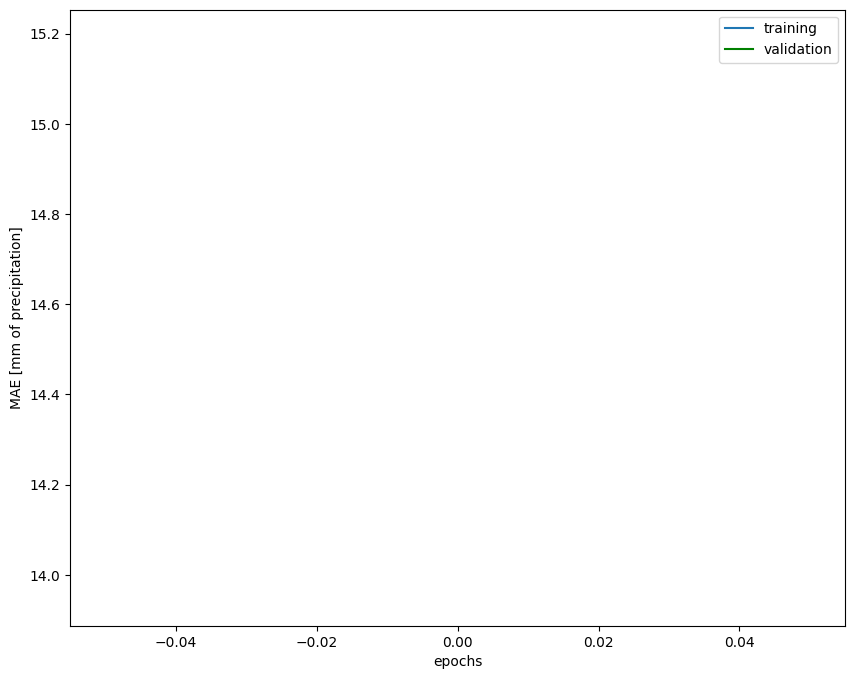

In [49]:
plt.figure(figsize=(10, 8))
plt.plot(training_hist_df.epoch, training_hist_df.loss, label='training')
plt.plot(training_hist_df.epoch, training_hist_df.val_loss, c='g', label='validation')
plt.legend()
plt.ylabel('MAE [mm of precipitation]')
plt.xlabel('epochs')
plt.show()

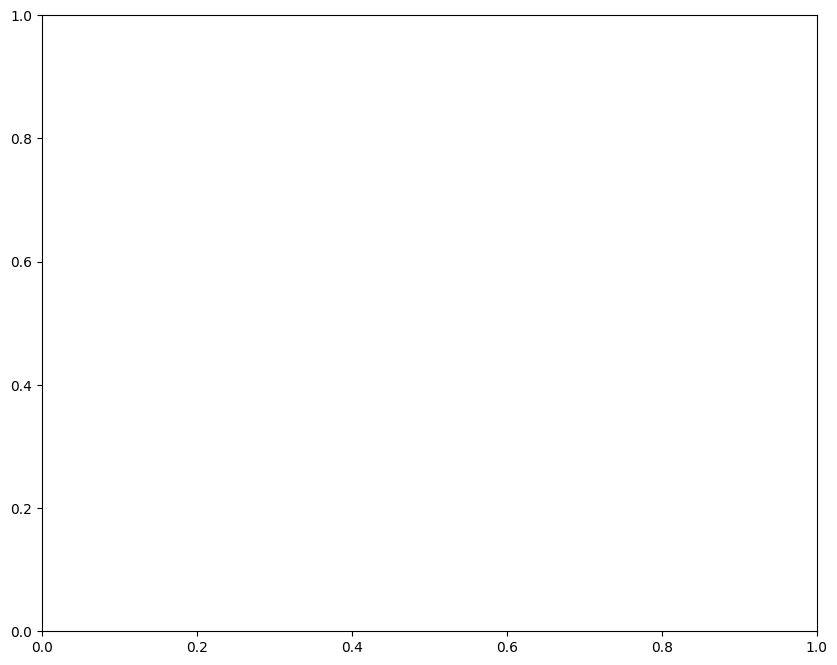

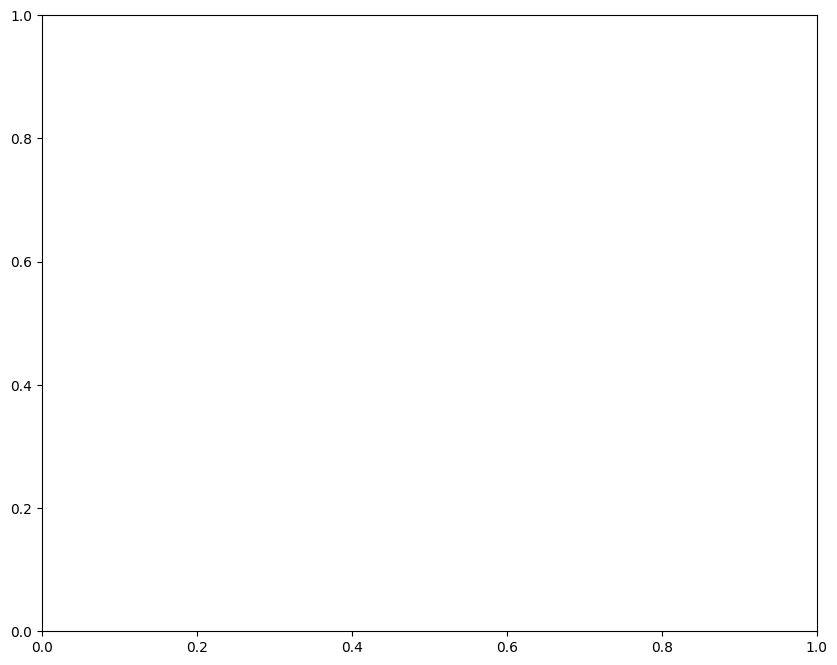

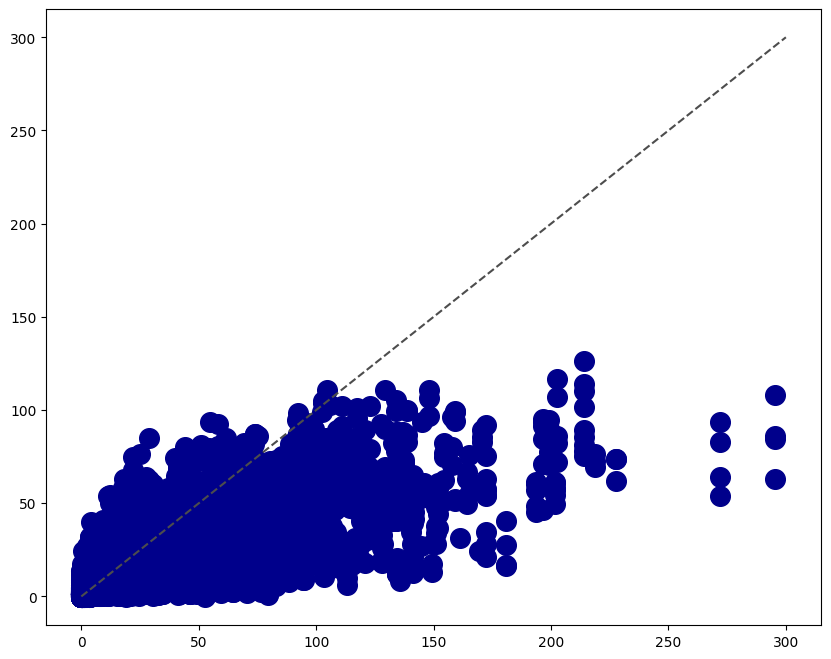

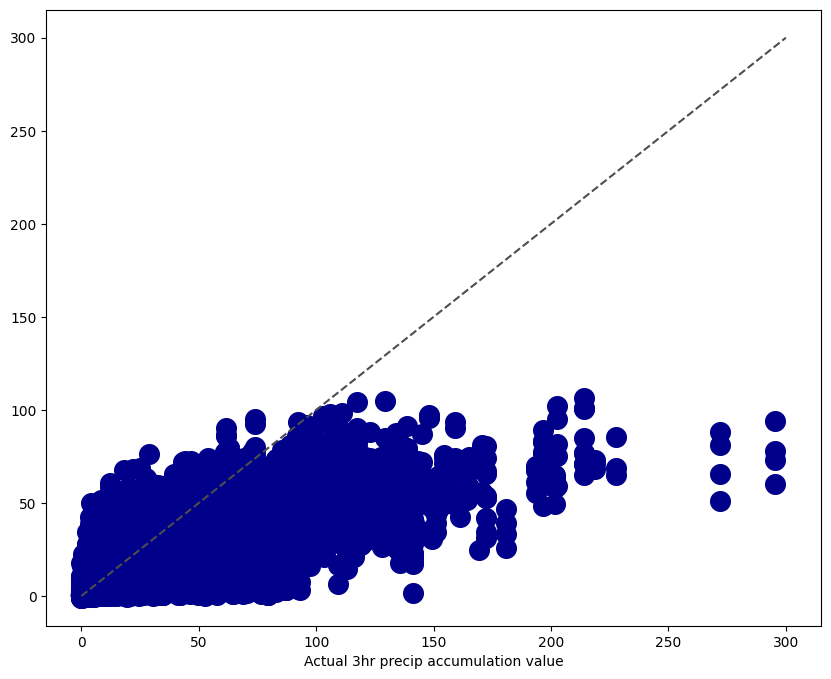

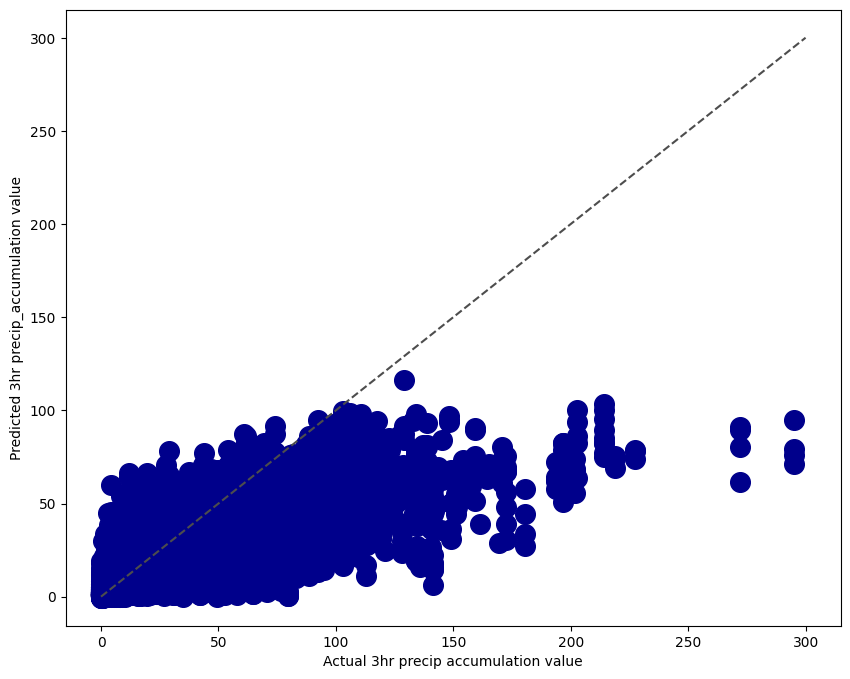

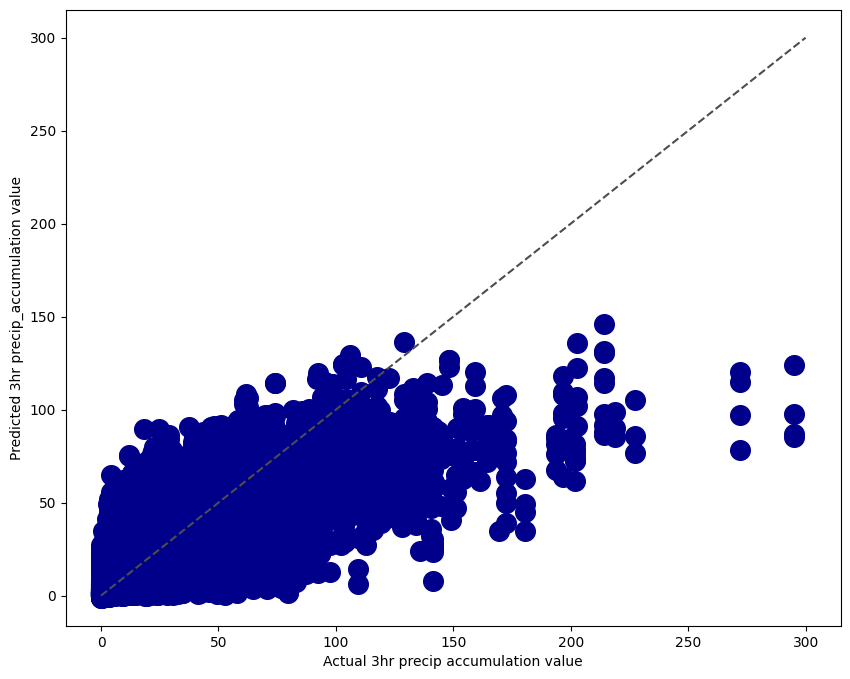

<Figure size 1000x800 with 0 Axes>

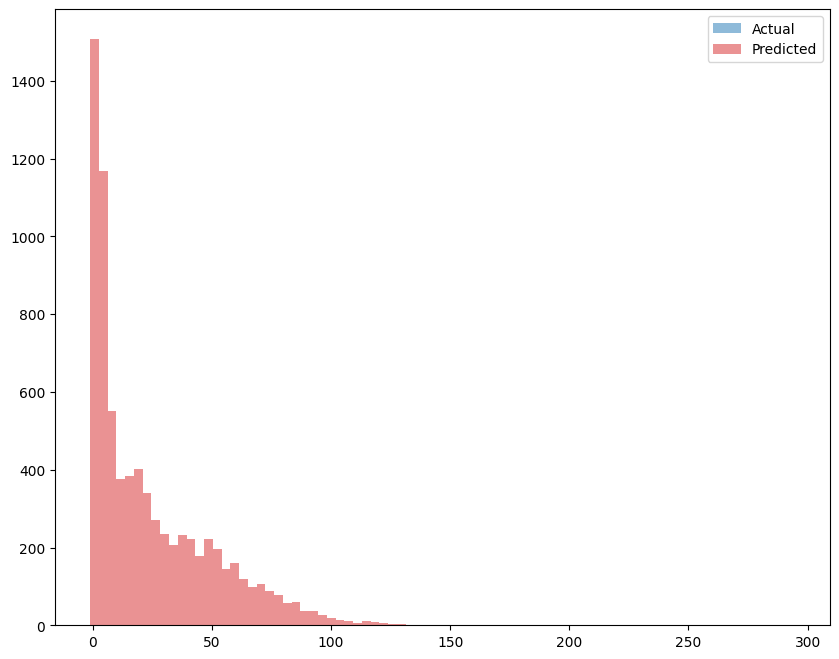

In [47]:
plt.figure(figsize=(10, 8))
plt.hist(data_splits['y_test'], alpha=0.5, bins=40, label='Actual')
plt.hist(y_pred, alpha=0.5, bins=40, label='Predicted')
plt.legend()
plt.show()